 ----------------------------------
 # Polymers (solutes) Estimator
 ----------------------------------

#####  Estimates solubility of requested polymers within given library of solvents as categorizing the solvents in which requested polymer can be soluble, non-soluble or theta (for neutral solubility)

- The model requires inputs of polymer molecular formula of the repeat unit, in terms of number of C, O, N, Cl, Br, and S elements and it's total Molecular weight. Inputs can be approximate


--------------------------
### Attribute Information:
--------------------------

1. **Solubility category: soluble, non-soluble and theta**
2. **Number of C, H, O, N, Cl, Br, S elements in solute (polymer unit)** 
3. **Tot_Mw of solute (polymer)**


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns

sns.set(color_codes=True) # adds a nice background to the graphs
%matplotlib inline 

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.preprocessing import FunctionTransformer  
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

In [3]:
import tensorflow
tensorflow.keras.__version__

'2.2.4-tf'

### Load the Data and Trained Model

In [22]:
#from tensorflow.keras.models import load_model

solubility_model = load_model("output/SolubilityModel4.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
# from tensorflow import keras
# solubility_model = keras.models.load_model("output/SolubilityModel6.keras")

In [24]:
X_data=pd.read_csv("output/X_model.csv")
y_data=pd.read_csv("output/y_model.csv")

In [25]:
del y_data['Unnamed: 0']
del X_data['Unnamed: 0']

In [26]:
X_data.head(3)

,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,C_solute,O_solute,N_solute,Cl_solute,Mw_solvent_logtrnsfmed,Mw_unit_solute_logtrnsfmed,tot_Mw_logtrnsfmed
0,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.497779,4.746184,12.301387
1,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.866808,4.746184,12.301387
2,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.855435,4.746184,12.301387


In [27]:
y_data.head(3)

,solubility_category
0,non-soluble
1,theta
2,non-soluble


### Split and Scale the X, y data

In [28]:
X = X_data
y = y_data['solubility_category']
print(X.shape, y.shape)

(2805, 14) (2805,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=110935, stratify=y, test_size=0.25)

In [30]:
X_scaler = MinMaxScaler().fit(X)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Label-encode data set
label_encoder = LabelEncoder()
#label_encoder.fit(y_train)
label_encoder.fit(y)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [32]:
# Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [33]:
print(y_test_categorical.shape)

(702, 3)


### Model Evaluation and Test

In [34]:
model_loss, model_accuracy = solubility_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {round(model_loss,2)}, Accuracy: {round(model_accuracy,2)}")

702/702 - 0s - loss: 0.5275 - acc: 0.8063
Normal Neural Network - Loss: 0.53, Accuracy: 0.8100000023841858


In [35]:
# Grab just one data point to test with
test = np.expand_dims(X_test_scaled[13], axis=0)
test.shape

(1, 14)

In [36]:
# Make a prediction

predicted = np.argmax(solubility_model.predict(test), axis=-1)
print(f"Predicted class: {predicted}")

Predicted class: [1]


In [37]:
encoded_prediction = label_encoder.inverse_transform(predicted)

In [38]:
actual_result = np.expand_dims(y_test, axis=1)[13]

In [39]:
print(f"Predicted solubility: {encoded_prediction}, actual solubility: {actual_result}")


Predicted solubility: ['soluble'], actual solubility: ['soluble']


### Functions
 - Get Mw from all elemens in a raw
 - Calculate each element percenrage in a raw

In [40]:
# get element dictionary set  
element_info = pd.read_csv("data/element_info.csv")
elements=element_info['Element'].to_list()

element_dict ={}

for i in range(len(element_info)):
    element_dict.update({element_info['Element'][i]:element_info['Mw'][i]})
    

In [41]:
def get_Mw(df):

    df['Mw_unit']=0
    Mw=0
    for element in elements:
        Mw += df[element]*element_dict[element]
    
    df['Mw_unit'] = Mw
    
    return(df)


In [42]:
def calculate_elements_perc(df, x):
    
    for i in range(len(df)):
        df.loc[i, 'total_els']=df.iloc[i, x:x+7].sum()
    
    df.iloc[:, x:x+7]=df.iloc[:, x:x+7].div(df.loc[:,'total_els'], axis=0)*100 

    return(df)

### Input Polymer Unit Strcurture

In [43]:
solute_tt=pd.DataFrame()

for element in element_dict:
   solute_tt.loc[0, element]=int(input(f"input # {element} atoms in polymer unit formula: "))

solute_tt.loc[0, 'Mw_tot']=float(input("input total (approximate) polymer Mw: "))
solute_tt


input # C atoms in polymer unit formula: 6
input # H atoms in polymer unit formula: 10
input # O atoms in polymer unit formula: 2
input # N atoms in polymer unit formula: 0
input # Cl atoms in polymer unit formula: 0
input # Br atoms in polymer unit formula: 0
input # S atoms in polymer unit formula: 0
input total (approximate) polymer Mw: 50000


,C,H,O,N,Cl,Br,S,Mw_tot
0,6.0,10.0,2.0,0.0,0.0,0.0,0.0,50000.0


In [44]:
solute_tt=get_Mw(solute_tt)
solute_tt

,C,H,O,N,Cl,Br,S,Mw_tot,Mw_unit
0,6.0,10.0,2.0,0.0,0.0,0.0,0.0,50000.0,114.144


In [45]:
solute_tt=calculate_elements_perc(solute_tt, 0)
solute_tt

,C,H,O,N,Cl,Br,S,Mw_tot,Mw_unit,total_els
0,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [46]:
solvents_info=pd.read_csv("data/solvents_info.csv")
solvents_info.head(3)


,Solvent,Chem_structure,C,H,O,N,Cl,Br,S
0,Methanol,C1H4O1,1,4.00,1.00,0,0,0,0
1,Ethanol_96,C2H6.08O1.04,2,6.08,1.04,0,0,0,0
2,Ethanol_99p9,C2H6.02O1.01,2,6.02,1.01,0,0,0,0


In [47]:
solvents1 = get_Mw(solvents_info)
solvents1.head(3)


,Solvent,Chem_structure,C,H,O,N,Cl,Br,S,Mw_unit
0,Methanol,C1H4O1,1,4.00,1.00,0,0,0,0,32.04200
1,Ethanol_96,C2H6.08O1.04,2,6.08,1.04,0,0,0,0,46.78960
2,Ethanol_99p9,C2H6.02O1.01,2,6.02,1.01,0,0,0,0,46.24915


In [48]:
solvents1=solvents_info.copy()

solvents1=calculate_elements_perc(solvents1, 2)
solvents1.head(3)

,Solvent,Chem_structure,C,H,O,N,Cl,Br,S,Mw_unit,total_els
0,Methanol,C1H4O1,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,6.00
1,Ethanol_96,C2H6.08O1.04,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,9.12
2,Ethanol_99p9,C2H6.02O1.01,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,9.03


In [49]:
solute_tt

,C,H,O,N,Cl,Br,S,Mw_tot,Mw_unit,total_els
0,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [50]:
len(solvents1)

88

In [51]:
for i in range(1,len(solvents1)):
    solute_tt.loc[i, :]=solute_tt.iloc[0,:]
    
solute_tt.head(3)

,C,H,O,N,Cl,Br,S,Mw_tot,Mw_unit,total_els
0,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
1,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
2,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [52]:
len(solute_tt)

88

In [53]:
solute_tt=solute_tt.rename(columns={"Mw_unit":"Mw_solute"})
solute_tt.head(3)

,C,H,O,N,Cl,Br,S,Mw_tot,Mw_solute,total_els
0,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
1,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
2,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [54]:
solute_tt=solute_tt.rename(columns={"C":"C_solute", "H":"H_solute",
                                   "O":"O_solute", "N":"N_solute",
                                   "Cl":"Cl_solute", "Cl":"Cl_solute",
                                   "Br":"Br_solute","S":"S_solute"})
solute_tt.head(3)

,C_solute,H_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute,total_els
0,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
1,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
2,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


### Concat with Solvents Data

In [55]:
solute_tt_solvents=pd.concat([solvents1, solute_tt], axis=1)
solute_tt_solvents.head(10)

,Solvent,Chem_structure,C,H,O,N,Cl,Br,S,Mw_unit,...,C_solute,H_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute,total_els
0,Methanol,C1H4O1,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
1,Ethanol_96,C2H6.08O1.04,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
2,Ethanol_99p9,C2H6.02O1.01,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
3,n-Propanol,C3H8O1,25.000000,66.666667,8.333333,0.0,0.0,0.0,0.0,60.09600,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
4,n-Butanol,C4H10O1,26.666667,66.666667,6.666667,0.0,0.0,0.0,0.0,74.12300,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
5,Pentanol-1,C5H12O1,27.777778,66.666667,5.555556,0.0,0.0,0.0,0.0,88.15000,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
6,2-Ethyl_butanol,C6H14O1,28.571429,66.666667,4.761905,0.0,0.0,0.0,0.0,102.17700,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
7,2-Ethyl_hexanol,C8H18O1,29.629630,66.666667,3.703704,0.0,0.0,0.0,0.0,130.23100,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
8,Methyl_isobutyl_carbinol,C6H14O1,28.571429,66.666667,4.761905,0.0,0.0,0.0,0.0,102.17700,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
9,Propylene_glycol,C3H8O2,23.076923,61.538462,15.384615,0.0,0.0,0.0,0.0,76.09500,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [56]:
solute_tt_solvents=solute_tt_solvents.rename(columns={"C":"C_solvent",
    "H": "H_solvent",
    "O": "O_solvent",
    "N": "N_solvent",
    "Cl": "Cl_solvent",
    "Br": "Br_solvent",
    "S": "S_solvent",
    "Mw_unit":"Mw_solvent"})

solute_tt_solvents.head()

,Solvent,Chem_structure,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,Mw_solvent,...,C_solute,H_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute,total_els
0,Methanol,C1H4O1,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
1,Ethanol_96,C2H6.08O1.04,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
2,Ethanol_99p9,C2H6.02O1.01,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
3,n-Propanol,C3H8O1,25.000000,66.666667,8.333333,0.0,0.0,0.0,0.0,60.09600,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0
4,n-Butanol,C4H10O1,26.666667,66.666667,6.666667,0.0,0.0,0.0,0.0,74.12300,...,33.333333,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0


In [57]:
solute_tt_solvents.columns

Index(['Solvent', 'Chem_structure', 'C_solvent', 'H_solvent', 'O_solvent',
       'N_solvent', 'Cl_solvent', 'Br_solvent', 'S_solvent', 'Mw_solvent',
       'total_els', 'C_solute', 'H_solute', 'O_solute', 'N_solute',
       'Cl_solute', 'Br_solute', 'S_solute', 'Mw_tot', 'Mw_solute',
       'total_els'],
      dtype='object')

In [58]:
solute_tt_model=solute_tt_solvents.drop(['H_solute', 'total_els', 'Solvent', 'Chem_structure'], axis=1)
solute_tt_model.head(3)

,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,Mw_solvent,C_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute
0,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144
1,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144
2,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144


In [59]:
solute_tt_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   C_solvent   88 non-null     float64
 1   H_solvent   88 non-null     float64
 2   O_solvent   88 non-null     float64
 3   N_solvent   88 non-null     float64
 4   Cl_solvent  88 non-null     float64
 5   Br_solvent  88 non-null     float64
 6   S_solvent   88 non-null     float64
 7   Mw_solvent  88 non-null     float64
 8   C_solute    88 non-null     float64
 9   O_solute    88 non-null     float64
 10  N_solute    88 non-null     float64
 11  Cl_solute   88 non-null     float64
 12  Br_solute   88 non-null     float64
 13  S_solute    88 non-null     float64
 14  Mw_tot      88 non-null     float64
 15  Mw_solute   88 non-null     float64
dtypes: float64(16)
memory usage: 11.1 KB


In [60]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   C_solvent                   2805 non-null   float64
 1   H_solvent                   2805 non-null   float64
 2   O_solvent                   2805 non-null   float64
 3   N_solvent                   2805 non-null   float64
 4   Cl_solvent                  2805 non-null   float64
 5   Br_solvent                  2805 non-null   float64
 6   S_solvent                   2805 non-null   float64
 7   C_solute                    2805 non-null   float64
 8   O_solute                    2805 non-null   float64
 9   N_solute                    2805 non-null   float64
 10  Cl_solute                   2805 non-null   float64
 11  Mw_solvent_logtrnsfmed      2805 non-null   float64
 12  Mw_unit_solute_logtrnsfmed  2805 non-null   float64
 13  tot_Mw_logtrnsfmed          2805 

In [61]:
log_transformer = FunctionTransformer(np.log1p)

log_transformer

FunctionTransformer(func=<ufunc 'log1p'>)

In [62]:
# Log Transform the molecular weights

for i in ['Mw_solvent', 'Mw_solute', 'Mw_tot']:
    solute_tt_model[i+'_logtrnsfmed'] = log_transformer.fit_transform(solute_tt_model[[i]])   

solute_tt_model.head(3)

/Users/grinn/opt/anaconda3/envs/py371/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,Mw_solvent,C_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute,Mw_solvent_logtrnsfmed,Mw_solute_logtrnsfmed,Mw_tot_logtrnsfmed
0,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,3.497779,4.746184,10.819798
1,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,3.866808,4.746184,10.819798
2,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,33.333333,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,3.855435,4.746184,10.819798


In [63]:
solute_tt_model.drop(['Mw_solvent', 'Mw_solute', 'Mw_tot', 'Br_solute', 'S_solute'], axis=1, inplace=True)
solute_tt_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   C_solvent               88 non-null     float64
 1   H_solvent               88 non-null     float64
 2   O_solvent               88 non-null     float64
 3   N_solvent               88 non-null     float64
 4   Cl_solvent              88 non-null     float64
 5   Br_solvent              88 non-null     float64
 6   S_solvent               88 non-null     float64
 7   C_solute                88 non-null     float64
 8   O_solute                88 non-null     float64
 9   N_solute                88 non-null     float64
 10  Cl_solute               88 non-null     float64
 11  Mw_solvent_logtrnsfmed  88 non-null     float64
 12  Mw_solute_logtrnsfmed   88 non-null     float64
 13  Mw_tot_logtrnsfmed      88 non-null     float64
dtypes: float64(14)
memory usage: 9.8 KB


/Users/grinn/opt/anaconda3/envs/py371/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [64]:
X_tt=solute_tt_model

In [65]:
solute_tt_model.head()

,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,C_solute,O_solute,N_solute,Cl_solute,Mw_solvent_logtrnsfmed,Mw_solute_logtrnsfmed,Mw_tot_logtrnsfmed
0,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.497779,4.746184,10.819798
1,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.866808,4.746184,10.819798
2,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,3.855435,4.746184,10.819798
3,25.000000,66.666667,8.333333,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,4.112446,4.746184,10.819798
4,26.666667,66.666667,6.666667,0.0,0.0,0.0,0.0,33.333333,11.111111,0.0,0.0,4.319127,4.746184,10.819798


In [66]:
X_tt_scaled = X_scaler.transform(X_tt)
X_tt_scaled.shape

(88, 14)

In [67]:
# Make predictions for requested polymer unit

predictions=np.argmax(solubility_model.predict(X_tt_scaled), axis=-1)

In [68]:
encoded_results = label_encoder.inverse_transform(predictions)

In [69]:
pred_model_df = pd.DataFrame({"Predicted_solubility_category": encoded_results})
pred_model_df.head()

,Predicted_solubility_category
0,non-soluble
1,non-soluble
2,non-soluble
3,non-soluble
4,non-soluble


(array([0, 1, 2]),
 [Text(0, 0, 'non-soluble'), Text(1, 0, 'soluble'), Text(2, 0, 'theta')])

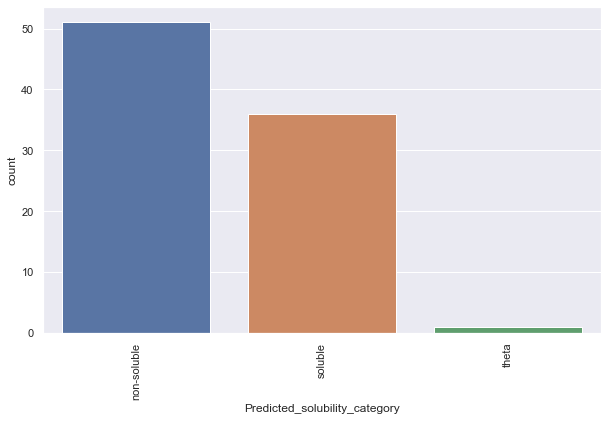

In [70]:
sns.set(rc={'figure.figsize':(10,6)})
sns.countplot(data=pred_model_df,x='Predicted_solubility_category')
plt.xticks(rotation=90)

In [71]:
pred_model_df['Predicted_solubility_category'].value_counts(normalize=True)*100

non-soluble    57.954545
soluble        40.909091
theta           1.136364
Name: Predicted_solubility_category, dtype: float64

In [72]:
pred_model_df['Predicted_solubility_category'].value_counts()

non-soluble    51
soluble        36
theta           1
Name: Predicted_solubility_category, dtype: int64

In [73]:
pred_results=pd.concat([solute_tt_solvents, pred_model_df], axis=1)
pred_results.head()

,Solvent,Chem_structure,C_solvent,H_solvent,O_solvent,N_solvent,Cl_solvent,Br_solvent,S_solvent,Mw_solvent,...,H_solute,O_solute,N_solute,Cl_solute,Br_solute,S_solute,Mw_tot,Mw_solute,total_els,Predicted_solubility_category
0,Methanol,C1H4O1,16.666667,66.666667,16.666667,0.0,0.0,0.0,0.0,32.04200,...,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0,non-soluble
1,Ethanol_96,C2H6.08O1.04,21.929825,66.666667,11.403509,0.0,0.0,0.0,0.0,46.78960,...,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0,non-soluble
2,Ethanol_99p9,C2H6.02O1.01,22.148394,66.666667,11.184939,0.0,0.0,0.0,0.0,46.24915,...,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0,non-soluble
3,n-Propanol,C3H8O1,25.000000,66.666667,8.333333,0.0,0.0,0.0,0.0,60.09600,...,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0,non-soluble
4,n-Butanol,C4H10O1,26.666667,66.666667,6.666667,0.0,0.0,0.0,0.0,74.12300,...,55.555556,11.111111,0.0,0.0,0.0,0.0,50000.0,114.144,18.0,non-soluble


In [74]:
pred_solvents=pred_results[['Solvent', 'Predicted_solubility_category']]
pred_solvents.head(3)

,Solvent,Predicted_solubility_category
0,Methanol,non-soluble
1,Ethanol_96,non-soluble
2,Ethanol_99p9,non-soluble


In [75]:
soluble_df=pred_solvents.loc[(pred_solvents['Predicted_solubility_category']=='soluble')]
soluble_df.head()

,Solvent,Predicted_solubility_category
14,m-Cresol,soluble
15,Ethyl_lactate,soluble
16,n-Butyl_lactate,soluble
18,Dipropylene_glycol,soluble
20,Methyl_dioxitol,soluble


In [76]:
non_soluble_df=pred_solvents.loc[(pred_solvents['Predicted_solubility_category']=='non-soluble')]
theta_df=pred_solvents.loc[(pred_solvents['Predicted_solubility_category']=='theta')]

In [77]:
non_soluble_df.head()

,Solvent,Predicted_solubility_category
0,Methanol,non-soluble
1,Ethanol_96,non-soluble
2,Ethanol_99p9,non-soluble
3,n-Propanol,non-soluble
4,n-Butanol,non-soluble


In [78]:
theta_df

,Solvent,Predicted_solubility_category
31,Carbon_disulfide,theta


In [79]:
print(f'for requested structure there are {len(soluble_df)} soluble, {len(non_soluble_df)} non-soluble, and {len(theta_df)} theta solvents')

for requested structure there are 36 soluble, 51 non-soluble, and 1 theta solvents


In [142]:
soluble_df.to_csv("output/pred_soluble_pmma.csv")
non_soluble_df.to_csv("output/pred_non_soluble_pmma.csv")
theta_df.to_csv("output/pred_theta_pmma.csv")

                                         **end of solutes estimator**